# Neural Style Transfer 

In [44]:
!curl -O https://en.wikipedia.org/wiki/Erling_Haaland/media/File:Erling_Haaland_2023_(cropped-v2).jpg
!curl -O https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg


zsh:1: no matches found: https://en.wikipedia.org/wiki/Erling_Haaland/media/File:Erling_Haaland_2023_(cropped-v2).jpg
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2621k  100 2621k    0     0  2091k      0  0:00:01  0:00:01 --:--:-- 2102k


In [64]:
import matplotlib.pyplot as plt
import tensorflow.keras as kr
import tensorflow as tf
import numpy as np
from IPython import display
from PIL import Image




In [65]:
CONTENT = 'Erling_Haaland_2023_(cropped-v2).jpeg'
STYLE = 'The_Great_Wave_off_Kanagawa.jpg'

IMAGE_HEIGHT = 300
IMAGE_WIDTH = 400

## Visualize the input

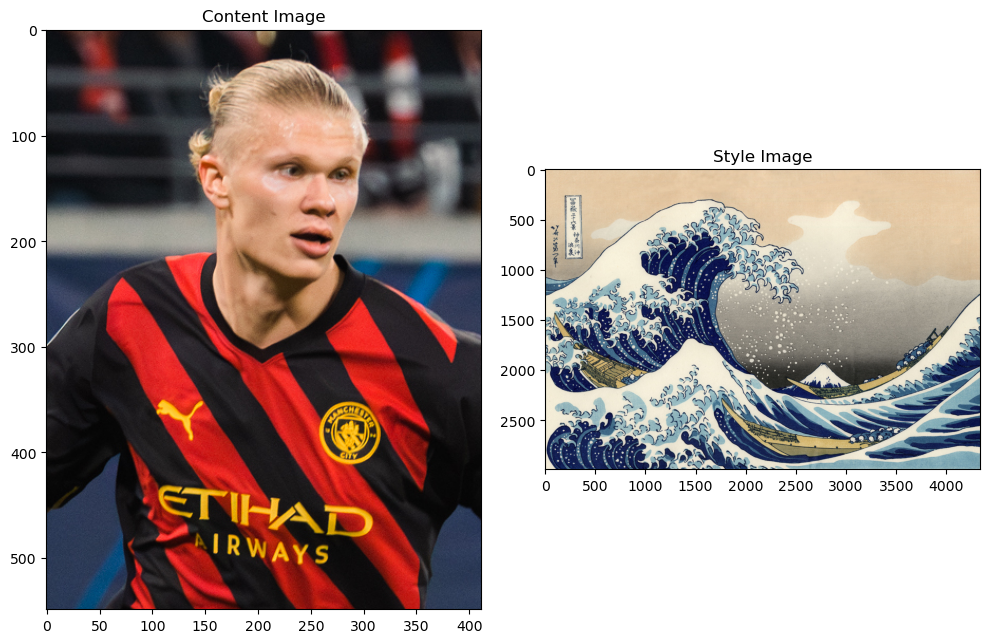

In [66]:
content = Image.open(CONTENT)
style = Image.open(STYLE)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title('Style Image')

plt.tight_layout()
plt.show()

In [67]:
def img_parser(filename):
    img_string = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_string, channels=3)
    img = tf.cast(img, dtype=tf.float32)

    # Resize the image
    img = tf.image.resize(img, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.expand_dims(img, axis=0)   # Add batch dimension
    return img

In [68]:
def load_image(filename):
    img = img_parser(filename)
    img = kr.applications.vgg19.preprocess_input(img)
    return img

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Also,  we must clip to maintain our values from within the 0-255 range.   

In [69]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert back to RGB from BGR

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [70]:
_vgg = kr.applications.vgg19.VGG19(include_top=False, 
                                   weights=None, 
                                   input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
_vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 100, 128)      0     

In [71]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

## Build the Model 

Let's create a model that will take an input image and output the content and style intermediate layers

In [72]:
def get_model(styles, contents):

    vgg = kr.applications.vgg19.VGG19(include_top=False, 
                                      weights='imagenet', 
                                      input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    vgg.trainable = False
    
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(layer_name).output for layer_name in styles]
    content_outputs = [vgg.get_layer(layer_name).output for layer_name in contents]
    model_outputs = style_outputs + content_outputs
   
    return kr.Model(vgg.input, model_outputs)

In [73]:
def get_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

## Style Loss

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. We will calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. 

After generating the Style matrix (Gram matrix), we will minimize the distance between the Gram matrix of the image S and image G. For now, we can derive the loss using only a single hidden layer $a^{[l]}$, and the corresponding style loss for this layer is defined as: 

$$L_{style}^{[l]}(S,G) = \sum_{i,j}(Gram^{(S)}_{ij} - Gram^{(G)}_{ij})^2 $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the style image and the generated image, computed using the hidden layer activations for a particular hidden layer in the network.

It turns out that you get more visually pleasing results if you use the style loss function from multiple different layers. So, the overall style cost function, we can define as:

$$L_{style}(S,G) = \sum_{l} \lambda^{[l]} L^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [74]:
def get_layer_style_loss(style, generated):
    def gram_matrix(tensor):
        channels = int(tensor.shape[-1])
        a = tf.reshape(tensor, [-1, channels])
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(tf.shape(a)[0], tf.float32)

    gram_style = gram_matrix(style)
    gram_generated = gram_matrix(generated)
    return tf.reduce_mean(tf.square(gram_style - gram_generated))


def get_style_loss(style, generated):
    loss = 0
    coeffs = [0.2, 0.2, 0.2, 0.2, 0.2]
    for s, g, coeff in zip(style, generated, coeffs):
        loss += coeff * get_layer_style_loss(s, g)
    
    return loss

## Define Total Loss

This is where we will combine style and content losses together. 

$$L(G) = \alpha L_{content}(C,G) + \beta L_{style}(S,G)$$ 

In [75]:
def compute_loss(model, image, style_features, content_features, alpha=0.1, beta=0.002):
    """This function will compute the loss total loss.
  
    Parameters:
    -----------
    model: kr.Model 
        The model that will give us access to the intermediate layers
    image: Tensor
        Initial image. This is what we are updating with the optimization process. 
    style_features: Tensor
        Precomputed style features from our Style image.
    content_features: Tensor
        Precomputed content features from our Content image.
      
    Returns:
    loss: Tensor
        Returns the total loss
    """

    # Feed our init image through our model.
    model_outputs = model(image)

    content_generated = [content_layer[0] for content_layer in model_outputs[len(style_layers):]][0]
    style_generated = [style_layer for style_layer in model_outputs[:len(style_layers)]]
    
    content_loss = alpha * get_content_loss(content_features, content_generated)
    style_loss = beta * get_style_loss(style_features, style_generated)

    # Get total loss
    loss = style_loss + content_loss
    return loss

In [76]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        loss = compute_loss(**cfg)
    # Compute gradients with respect to input image
    return tape.gradient(loss, cfg['image']), loss

## Apply Style Transfer to Images

In [77]:
def transfer_style(content_img, style_img, epochs=1000): 
    def generate_noisy_image(content_image, noise_ratio):
        """Generates a noisy image by adding random noise to the content image"""
    
        noise_image = tf.random.uniform([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3], minval=-20, maxval=20)
        input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
        return input_image

    # We don't want to train any layers of our model 
    model = get_model(style_layers, content_layers) 
    for layer in model.layers:
        layer.trainable = False
        
    S = load_image(style_img)
    C = load_image(content_img)

    style_outputs = model(S)
    content_outputs = model(C)

    # Get the style and content feature representations (from our specified intermediate layers) 
    _content = [content_layer[0] for content_layer in content_outputs[len(style_layers):]][0]
    _style = [style_layer[0] for style_layer in style_outputs[:len(style_layers)]]
  
    # Set initial image
    G = generate_noisy_image(C, 0.6)
    G = tf.Variable(G, dtype=tf.float32)


    best_loss, best_img = float('inf'), None
  
    # Create a nice config 
    cfg = {
        'model': model,
        'image': G,
        'style_features': _style,
        'content_features': _content
    }
    
    # Create our optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=2, beta_1=0.99, epsilon=1e-1)

    # For displaying
    display_interval = epochs/(2*5)
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grads, cost = compute_grads(cfg)
        opt.apply_gradients([(grads, G)])
        clipped = tf.clip_by_value(G, min_vals, max_vals)
        G.assign(clipped)
        
        if cost < best_loss:
            best_loss = cost
            best_img = deprocess_img(G.numpy())

        if i % display_interval== 0:
            plot_img = G.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            display.clear_output(wait=True)
            display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}, LOSS: {:.4e}'.format(i, cost))
        
            
    display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss 

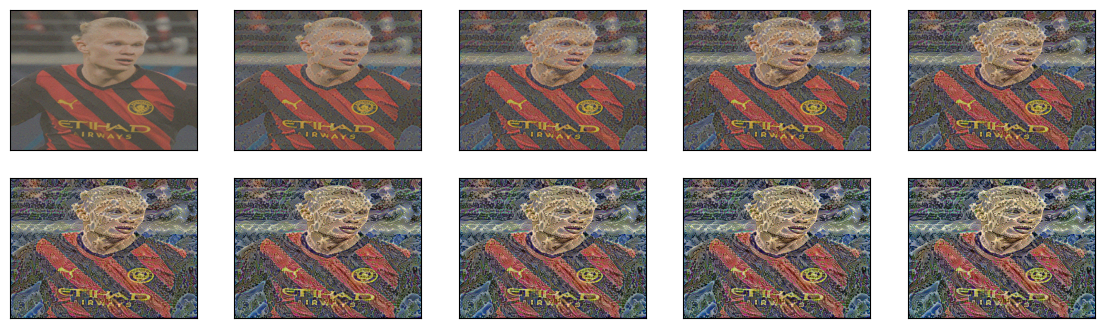

In [78]:
best, best_loss = transfer_style(CONTENT, STYLE, epochs=100)

## Visualize Outputs 

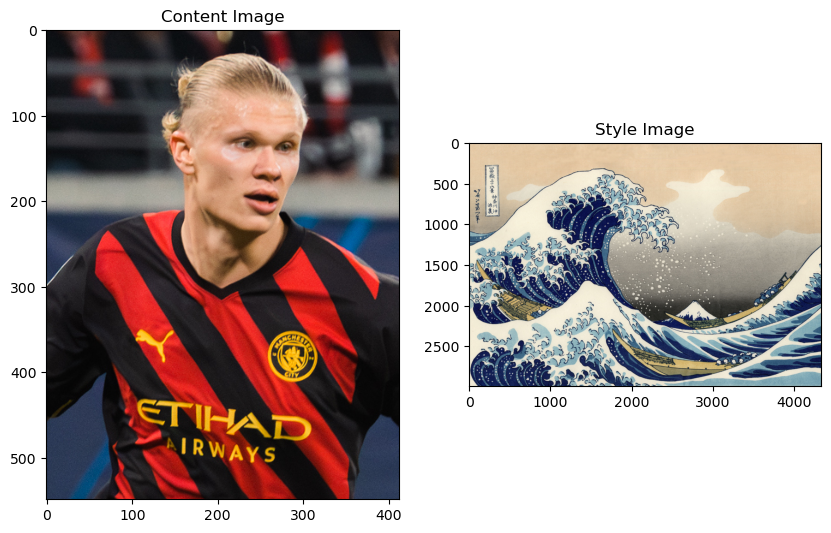

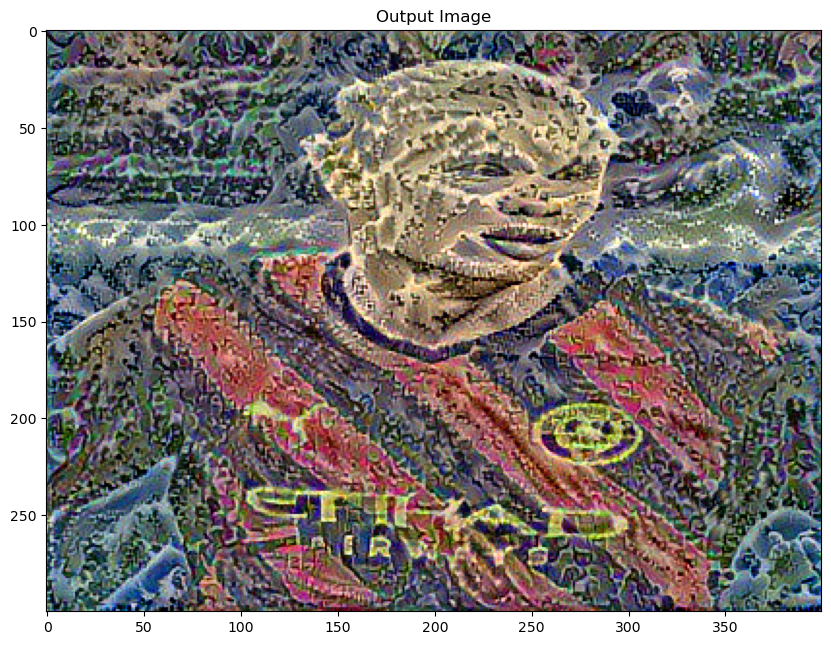

In [79]:
plt.figure(figsize=(10, 10))
content = Image.open(CONTENT) 
style = Image.open(STYLE)

plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title('Style Image')

plt.figure(figsize=(10, 10))

plt.imshow(best)
plt.title('Output Image')
plt.show()